In [5]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import keras
import matplotlib.pyplot as plt
import h5py
import itertools

from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adamax
from tensorflow.keras.applications import VGG16, InceptionResNetV2, ResNet50, Xception
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall, AUC, TruePositives, TrueNegatives, FalsePositives, FalseNegatives
from keras_tuner.tuners import RandomSearch
import keras_tuner as kt
from glob import glob
import kerastuner as kt
from keras_tuner import HyperParameters

print("Importações e dependencias adicionadas com sucesso.")

Importações e dependencias adicionadas com sucesso.


C:\Users\mariana\AppData\Local\Temp\ipykernel_23076\175168220.py:26: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


### DataPath

Contagem do número de ficheiros e quantidade de imagens em cada classe de doença de pele (**Urticaria**, **Psoriasis**, **Lupus**, **Dermatite**, **Melanoma**).

| Classe de Doença de Pele                                     | Conjunto de Treino | Conjunto de Teste |
|---------------------------------------------------------------|--------------------|-------------------|
| URTICARIA HIVES                                              | 416                | 53                |
| PSORIASIS PICTURES LICHEN PLANUS AND RELATED DISEASES        | 483                | 350               |
| LUPUS AND OTHER CONNECTIVE TISSUE DISEASES                   | 416                | 105               |
| ATOPIC DERMATITIS PHOTOS                                     | 483                | 123               |
| MELANOMA SKIN CANCER NEVI AND MOLES                          | 453                | 115               |

Total number of images in [ATOPIC DERMATITIS PHOTOS] in train set: 483
Total number of images in [LUPUS AND OTHER CONNECTIVE TISSUE DISEASES] in train set: 416
Total number of images in [MELANOMA SKIN CANCER NEVI AND MOLES] in train set: 453
Total number of images in [PSORIASIS PICTURES LICHEN PLANUS AND RELATED DISEASES] in train set: 483
Total number of images in [URTICARIA HIVES] in train set: 416
Total number of images in [ATOPIC DERMATITIS PHOTOS] in test set: 123
Total number of images in [LUPUS AND OTHER CONNECTIVE TISSUE DISEASES] in test set: 105
Total number of images in [MELANOMA SKIN CANCER NEVI AND MOLES] in test set: 115
Total number of images in [PSORIASIS PICTURES LICHEN PLANUS AND RELATED DISEASES] in test set: 350
Total number of images in [URTICARIA HIVES] in test set: 53
Labels:  ['Atopic Dermatitis Photos', 'Lupus and other Connective Tissue diseases', 'Melanoma Skin Cancer Nevi and Moles', 'Psoriasis pictures Lichen Planus and related diseases', 'Urticaria Hives']

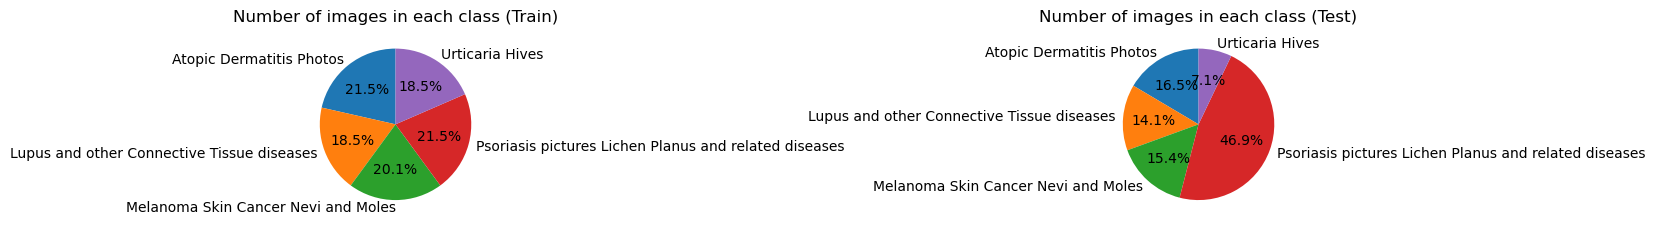

In [6]:
# Função para contar o número de arquivos 
def count_files(directory):
    return len([item for item in os.listdir(directory) if os.path.isfile(os.path.join(directory, item))])

# Caminhos dos diretórios de treino e teste
#train_folder = '/Users/hugopereira/Github/Left4Health_3rdProject/ClassificationOfSkinDiseases/DataProcessed/train'
#test_folder = '/Users/hugopereira/Github/Left4Health_3rdProject/ClassificationOfSkinDiseases/DataProcessed/test'

train_folder= 'C:/Dev/DataProcessed/train'
test_folder = 'C:/Dev/DataProcessed/test'


# Dicionários para armazenar o número de imagens em cada classe de doença de pele
train_diseases = {}
test_diseases = {}

# Função para contar o número de imagens em cada classe de doença de pele 
def count_images_in_folders(folder, diseases_dict):
    for label_folder in os.listdir(folder):
        label_path = os.path.join(folder, label_folder)
        if os.path.isdir(label_path):
            diseases_dict[label_folder] = count_files(label_path)

# Contagem do número de imagens em cada classe de doença de pele 
count_images_in_folders(train_folder, train_diseases)
count_images_in_folders(test_folder, test_diseases)

# Print do número de imagens em cada classe de doença de pele nos conjuntos de treino e teste
for label_folder, num_images in train_diseases.items():
    print(f'Total number of images in [{label_folder.upper()}] in train set: {num_images}')

for label_folder, num_images in test_diseases.items():
    print(f'Total number of images in [{label_folder.upper()}] in test set: {num_images}')

y=list(train_diseases.keys())
print("Labels: ",y)

# Plot do número de imagens em cada classe de doença de pele nos conjuntos de treino e teste 
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.pie(train_diseases.values(), labels=train_diseases.keys(), autopct='%1.1f%%', startangle=90)
plt.title('Number of images in each class (Train)')

plt.subplot(1, 2, 2)
plt.pie(test_diseases.values(), labels=test_diseases.keys(), autopct='%1.1f%%', startangle=90)
plt.title('Number of images in each class (Test)')

plt.tight_layout()
plt.show()

## Defnição de funções 

### Obtenção dos Dados de Treino, Validação e Teste

Definição de uma função para obter os dados de treino, validação e teste.

#### Funcionalidades Principais:

- **Função `get_data(train_folder, test_folder, image_size=(250, 250), batch_size=32)`:** Retorna geradores de dados para treino, validação e teste.
- **Pré-processamento dos Dados de Treino:** Utiliza `ImageDataGenerator` para aplicar transformações nos dados de treino, como redimensionamento, normalização e aumento de dados.
- **Divisão em Conjuntos de Treino e Validação:** Divide os dados de treino em conjuntos de treino e validação.
- **Pré-processamento dos Dados de Teste:** Aplica redimensionamento e normalização nos dados de teste.
- **Geradores de Dados:** Cria geradores de dados para treino, validação e teste, utilizando as configurações definidas.


In [7]:
def get_data(train_folder, test_folder, image_size=(250, 250), batch_size=32):
    # Data augmentation para o conjunto de treinamento
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,  # Fixando a divisão em 80% treino e 20% validação
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=20,
    )

    # Carregar dados de treinamento e validação
    train_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',  # Define o subset como treinamento
        seed=10
    )

    validation_generator = train_datagen.flow_from_directory(
        train_folder,   
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',  # Define o subset como validação
        seed=10
    )

    # Obtendo o mapeamento de classes para índices
    class_indices = train_generator.class_indices

    # Invertendo o mapeamento para obter índices para classes
    indices_class = {v: k for k, v in class_indices.items()}

    # Inicializando um contador para cada classe
    class_counts_train = {class_name: 0 for class_name in indices_class.values()}

    # Iterando sobre o diretório de treinamento e contando o número de imagens em cada classe
    for class_name in class_counts_train.keys():
        class_folder = os.path.join(train_folder, class_name)
        num_images = len(os.listdir(class_folder))
        class_counts_train[class_name] = num_images

    # Data augmentation para o conjunto de teste
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Carregar dados de teste
    test_generator = test_datagen.flow_from_directory(
        test_folder,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    # Obtendo o número de imagens por classe no conjunto de teste
    class_counts_test = {class_name: len(os.listdir(os.path.join(test_folder, class_name))) for class_name in class_counts_train.keys()}

    # Obtendo o número de imagens por classe no conjunto de validação
    class_counts_validation = {class_name: len(os.listdir(os.path.join(train_folder, class_name))) for class_name in class_counts_train.keys()}

    # Imprimindo o número de imagens para cada classe no conjunto de validação
    print("\nNúmero de imagens por classe no conjunto de validação:")
    for class_name, count in class_counts_validation.items():
        print(f"Classe: {class_name}, Número de Imagens: {count}")
    
    return train_generator, validation_generator, test_generator, class_counts_train, class_counts_test,class_counts_validation

train_generator, validation_generator, test_generator, class_counts_train, class_counts_test,class_counts_validation = get_data(train_folder, test_folder)

# Imprimindo o número de imagens para cada classe no conjunto de treinamento
print("Número de imagens por classe no conjunto de treinamento:")
for class_name, count in class_counts_train.items():
    print(f"Classe: {class_name}, Número de Imagens: {count}")

# Imprimindo o número de imagens para cada classe no conjunto de validação
print("\nNúmero de imagens por classe no conjunto de validação:")
for class_name, count in class_counts_validation.items():
    print(f"Classe: {class_name}, Número de Imagens: {count}")

# Imprimindo o número de imagens para cada classe no conjunto de teste
print("\nNúmero de imagens por classe no conjunto de teste:")
for class_name, count in class_counts_test.items():
    print(f"Classe: {class_name}, Número de Imagens: {count}")


Found 1803 images belonging to 5 classes.
Found 448 images belonging to 5 classes.
Found 746 images belonging to 5 classes.

Número de imagens por classe no conjunto de validação:
Classe: Atopic Dermatitis Photos, Número de Imagens: 483
Classe: Lupus and other Connective Tissue diseases, Número de Imagens: 416
Classe: Melanoma Skin Cancer Nevi and Moles, Número de Imagens: 453
Classe: Psoriasis pictures Lichen Planus and related diseases, Número de Imagens: 483
Classe: Urticaria Hives, Número de Imagens: 416
Número de imagens por classe no conjunto de treinamento:
Classe: Atopic Dermatitis Photos, Número de Imagens: 483
Classe: Lupus and other Connective Tissue diseases, Número de Imagens: 416
Classe: Melanoma Skin Cancer Nevi and Moles, Número de Imagens: 453
Classe: Psoriasis pictures Lichen Planus and related diseases, Número de Imagens: 483
Classe: Urticaria Hives, Número de Imagens: 416

Número de imagens por classe no conjunto de validação:
Classe: Atopic Dermatitis Photos, Númer

### Treino dos Modelos

Definição de uma função para treinar os modelos de classificação.

#### Funcionalidades Principais:

- **Função `train_model(model, train_generator, validation_generator, epochs)`:** Compila e treina o modelo de classificação.
- **Compilação do Modelo:** Utiliza o otimizador 'adam' e a função de perda 'categorical_crossentropy' para compilar o modelo. Além disso, utiliza a métrica de accuracy e precisão durante o treino.
- **Treino do Modelo:** Treina o modelo utilizando os geradores de dados de treino e validação, durante o número especificado de épocas.
- **Retorno do Modelo e Histórico:** Retorna o modelo treinado e o histórico de treino.


In [8]:
# Função para treinar os modelos
def train_model(model, train_generator, validation_generator, epochs):
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy', Precision()]
    )

    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        verbose=1,
    )

    return model, history

### Avaliação dos Modelos

Definição de uma função para avaliar o desempenho dos modelos.

#### Funcionalidades Principais:

- **Função `evaluate_model(model, history, test_generator, test_folder)`:** Avalia o modelo de classificação.
- **Previsões:** Utiliza o modelo para fazer previsões sobre os dados de teste.
- **Conversão das Previsões para Rótulos:** Converte as previsões em rótulos para comparação com os rótulos verdadeiros.
- **Cálculo da Precisão, Recall e AUC:** Calcula a precisão, recall e AUC do modelo utilizando as previsões e os rótulos verdadeiros.
- **Visualização dos Resultados:** Plot da precisão, recall, AUC, bem como a precisão e perda de treino e validação em cada época.

In [9]:
# Função para avaliar os modelos
def evaluate_model(model, history, test_generator, test_folder): 
    # Prever
    y_pred = model.predict(test_generator)

    # Converter as previsões em rótulos
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = test_generator.classes

    # Calcular precisão, recall e exatidão
    precision = precision_score(y_true_labels, y_pred_labels, average='weighted', zero_division=0)
    recall = recall_score(y_true_labels, y_pred_labels, average='weighted', zero_division=0)
    accuracy = accuracy_score(y_true_labels, y_pred_labels)

    # O cálculo da AUC não é possível sem y_score (probabilidades de classe)
    # auc = roc_auc_score(y_true_labels, y_pred_labels, average='weighted', multi_class='ovr')

    # Gráfico da precisão e perda de treino e validação em cada época
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    
    # Gráfico da precisão de treino e validação do modelo
    plt.plot(history.history['accuracy'], label='Precisão de Treino')
    plt.plot(history.history['val_accuracy'], label='Precisão de Validação')
    plt.title('Precisão de Treino e Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Precisão')
    plt.legend()

    # Gráfico da perda de treino e validação em cada época
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Perda de Treino')
    plt.plot(history.history['val_loss'], label='Perda de Validação')
    plt.title('Perda de Treino e Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    plt.tight_layout()

    print("Precision:", precision)
    print("Recall:", recall)
    print("Accuracy:", accuracy)
    # print("AUC:", auc)

    plt.show()

### Guardar os Modelos

Definição de uma função para salvar os modelos treinados, juntamente com sua avaliação e histórico de treino.

#### Funcionalidades Principais:

- **Função `save_model(model, model_name, history, train_folder)`:** Salva o modelo treinado, sua avaliação e histórico de treinamento.
- **Criação de Pastas:** Cria pastas para salvar o modelo, a avaliação e o histórico, se não existirem.
- **Salvamento do Modelo:** Salva o modelo treinado em formato h5.
- **Avaliação do Modelo:** Avalia o modelo e salva a avaliação em uma figura.
- **Salvamento da Arquitetura do Modelo:** Plota e salva a arquitetura do modelo em uma imagem.
- **Salvamento do Histórico de Treinamento:** Salva o histórico de treinamento em um arquivo CSV.


In [10]:
# Função para guardar os modelos
def save_model(model, model_name, history, train_folder, test_folder, test_generator): 
    # Criar uma pasta para guardar os modelos se esta não existir
    if not os.path.exists('Modelos_Salvos'):
        os.mkdir('Modelos_Salvos')
    
    # Criar uma pasta para guardar o modelo se esta não existir
    if not os.path.exists('Modelos_Salvos/' + model_name):
        os.mkdir('Modelos_Salvos/' + model_name)
    
    # Guardar o modelo
    model.save('Modelos_Salvos/' + model_name + '/' + model_name + '.h5')

    # Guardar a avaliação do modelo usando o gerador de teste
    evaluate_model(model, history, test_generator, test_folder)
    plt.savefig('Modelos_Salvos/' + model_name + '/' + model_name + '_avaliacao.png')

    # Guardar a arquitetura do modelo
    tf.keras.utils.plot_model(
        model,
        to_file='Modelos_Salvos/' + model_name + '/' + model_name + '.png',
        show_shapes=True,
        show_layer_names=True,
    )

    # Guardar o histórico do modelo num ficheiro CSV
    hist_df = pd.DataFrame(history.history)
    hist_csv_file = 'Modelos_Salvos/' + model_name + '/' + model_name + '_historico.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)

In [11]:
# Função para carregar o modelo e seu histórico
def load_model_and_history(model_name):
    # Verifica se o modelo existe
    model_path = 'Modelos_Salvos/' + model_name + '/' + model_name + '.h5'
    if not os.path.exists(model_path):
        print("O modelo especificado não existe.")
        return None, None
    
    # Carrega o modelo
    model = tf.keras.models.load_model(model_path)
    
    # Carrega o histórico
    history_path = 'Modelos_Salvos/' + model_name + '/' + model_name + '_historico.csv'
    if os.path.exists(history_path):
        history = pd.read_csv(history_path)
    else:
        print("O histórico do modelo não existe.")
        history = None
    
    return model, history

### Matrix de Confussão

Definição de uma função para mostrar a matriz de confussão associada a um dado modelo

#### Funcionalidades Principais:

- **Função `confussion_matrix(y_true_labels, y_pred_labels, test_generator)`:** Calcula a matriz de confusão, exibindo-a em um gráfico de calor. Além disso, mostra o relatório de classificação e os valores de verdadeiros positivos (TP), verdadeiros negativos (TN), falsos positivos (FP) e falsos negativos (FN).
  - **Cálculo da Matriz de Confusão:** Utiliza a função `confusion_matrix` para calcular a matriz de confusão com as etiquetas verdadeiras e preditas.
  - **Exibição da Matriz de Confusão:** Plota a matriz de confusão em um gráfico de calor, utilizando a biblioteca seaborn para uma melhor visualização.
  - **Relatório de Classificação:** Mostra um resumo do desempenho do modelo, incluindo métricas como precisão, recall e F1-score para cada classe.
  - **Cálculo dos Valores de TP, TN, FP, FN:** Calcula e exibe os valores de verdadeiros positivos, verdadeiros negativos, falsos positivos e falsos negativos.

In [12]:
def confussion_matrix(y_true_labels,y_pred_labels,test_generator):
    # Calcular a matriz de confusão
    cm = confusion_matrix(y_true_labels, y_pred_labels)

    # Exibir a matriz de confusão
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Calcular os verdadeiros positivos (TP), verdadeiros negativos (TN),
    # falsos positivos (FP) e falsos negativos (FN)
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]

    # Exibir o relatório de classificação
    print("\nRelatório de Classificação:")
    print(classification_report(y_true_labels, y_pred_labels, target_names=test_generator.class_indices.keys()))

    # Exibir a tabela com os valores de TP, TN, FP, FN
    print("\nValores de TP, TN, FP, FN:")
    print("Verdadeiros Positivos:", TP)
    print("Verdadeiros Negativos:", TN)
    print("Falsos Positivos:", FP)
    print("Falsos Negativos:", FN)

## Modelos


### Compilação de Modelos COM TUNNING

Possui 2 metodos diferentes para arranjar os melhores hiperparametros:
    - **1.1** Metodo Random Search
    - **1.2** Metodo Grid Search

#### Random e Grid Search

In [13]:
#Definição do random search
def random_search(build_model, train_generator, test_generator, epochs, max_trials=10, executions_per_trial=8):
    tuner = RandomSearch(
        build_model,
        objective='val_accuracy',
        max_trials=max_trials,
        executions_per_trial=executions_per_trial,
        directory='test_tuner')

    tuner.search(train_generator,
                 epochs=epochs,
                 validation_data=test_generator,
                 batch_size=32)

    best_model = tuner.get_best_models(num_models=1)[0]

    history = best_model.fit(train_generator, validation_data=test_generator, epochs=epochs, verbose=1)

    # Obtendo o nome do modelo a partir da função de criação do modelo
    model_name = build_model.__name__ + '_randomsearch'
    
    # Salvando o modelo
    save_model(best_model,  model_name , history, train_folder, train_folder, test_generator)
    
    return best_model, history, model_name

In [14]:
#Definição do grid search
def grid_search(build_model, train_generator, test_generator, param_grid, epochs):
    best_accuracy = 0
    best_params = None
    best_model = None
    
    # Generate all combinations of parameters
    param_combinations = list(itertools.product(*param_grid.values()))
    
    for params in param_combinations:
        param_dict = dict(zip(param_grid.keys(), params))
        
        print("Training model with parameters:", param_dict)
        
        model = build_model(params=param_dict)
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        history = model.fit(train_generator, validation_data=test_generator, epochs=epochs, verbose=1)
        accuracy = history.history['val_accuracy'][-1]  # Use validation accuracy as the metric
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = param_dict
            best_model = model
                
    print("Best parameters:", best_params)
    print("Best validation accuracy:", best_accuracy)
    
    # Now you can train the final model with the best parameters
    final_model = build_model(params=best_params)
    final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    final_history = final_model.fit(train_generator, validation_data=test_generator, epochs=epochs, verbose=1)

   # Obtendo o nome do modelo a partir da função de criação do modelo
    model_name = build_model.__name__ + '_randomsearch'
    
    # Salvando o modelo
    save_model(best_model,  model_name , history, train_folder, train_folder, test_generator)
    
    return best_model, final_model, final_history, model_name


#### CNN 

In [19]:
# Definição da arquitetura da CNN
def CNN_model(hp=None, params=None):
    if hp is not None:
        # Se o objeto hp estiver presente, use-o para recuperar os hiperparâmetros
        filters = hp.Int('filters', min_value=16, max_value=128, step=16)
        kernel_size = hp.Choice('kernel_size', values=['3,3', '5,5'])  # Convertendo as tuplas em strings
        activation = hp.Choice('activation', values=['relu', 'tanh'])
        learning_rate = hp.Choice('learning_rate', values=[0.001, 0.01, 0.1])
        kernel_size = tuple(map(int, kernel_size.split(',')))  # Convertendo as strings de volta em tuplas
    elif params is not None:
        # Se o objeto params estiver presente, use-o para recuperar os hiperparâmetros
        filters = params.get('filters') if 'filters' in params else 64  # Valor padrão de 64 caso 'filters' não esteja presente em params
        kernel_size = params.get('kernel_size') if 'kernel_size' in params else '3,3'  # Valor padrão de '3,3' caso 'kernel_size' não esteja presente em params
        activation = params.get('activation') if 'activation' in params else 'relu'  # Valor padrão de 'relu' caso 'activation' não esteja presente em params
        learning_rate = params.get('learning_rate') if 'learning_rate' in params else 0.001  # Valor padrão de 0.001 caso 'learning_rate' não esteja presente em params
    else:
        raise ValueError("Ambos hp e params não podem ser None.")
    input_shape = (250, 250, 3)# Defina as dimensões corretas das imagens de entrad
    
    model = Sequential([
        Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, input_shape=input_shape, padding='same'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        Conv2D(filters=filters//2, kernel_size=kernel_size, activation=activation, padding='same'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        Conv2D(filters=filters//4, kernel_size=kernel_size, activation=activation, padding='same'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        GlobalAveragePooling2D(),
        Dense(units=64, activation='relu'),
        Dense(units=5, activation='softmax')
    ]) 
    
    opt = Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

Trial 2 Complete [00h 21m 11s]
val_accuracy: 0.3739946335554123

Best val_accuracy So Far: 0.46916890144348145
Total elapsed time: 00h 55m 10s
Epoch 1/10


2024-04-08 20:12:17.191496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - ETA: 0s - loss: 1.6116 - accuracy: 0.2196

2024-04-08 20:13:47.060106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 100s 2s/step - loss: 1.6116 - accuracy: 0.2196 - val_loss: 1.5962 - val_accuracy: 0.1649
Epoch 2/10
57/57 [==============================] - 99s 2s/step - loss: 1.6124 - accuracy: 0.2257 - val_loss: 1.6429 - val_accuracy: 0.1542
Epoch 3/10
57/57 [==============================] - 98s 2s/step - loss: 1.6164 - accuracy: 0.2207 - val_loss: 1.5763 - val_accuracy: 0.4692
Epoch 4/10
57/57 [==============================] - 98s 2s/step - loss: 1.6135 - accuracy: 0.2002 - val_loss: 1.5795 - val_accuracy: 0.4692
Epoch 5/10
57/57 [==============================] - 99s 2s/step - loss: 1.6124 - accuracy: 0.1980 - val_loss: 1.6510 - val_accuracy: 0.1542
Epoch 6/10
57/57 [==============================] - 98s 2s/step - loss: 1.6145 - accuracy: 0.1963 - val_loss: 1.5730 - val_accuracy: 0.4692
Epoch 7/10
57/57 [==============================] - 98s 2s/step - loss: 1.6224 - accuracy: 0.1797 - val_loss: 1.6082 - val_accuracy: 0.1649
Epoch 8/10
57/57 [============

2024-04-08 20:28:43.071448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


24/24 [==============================] - 10s 405ms/step
Precision: 0.023763916940393447
Recall: 0.15415549597855227
Accuracy: 0.15415549597855227


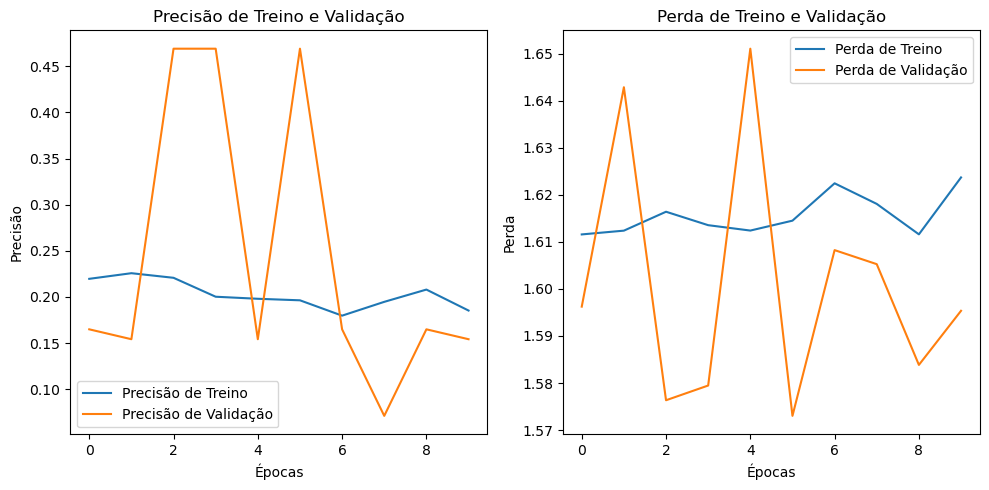

Modelo carregado com sucesso!
Arquitetura do modelo:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 250, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 125, 125, 128)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 125, 125, 128)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 dr

<Figure size 640x480 with 0 Axes>

In [20]:

#Utilização do Random Search
epochs=10
best_random_model, random_history, model_name= random_hyperparameter_search(
    CNN_model, 
    train_generator, 
    test_generator, 
    epochs,
    max_trials=2,  # Altere o número de tentativas conforme necessário
    executions_per_trial=2
)

loaded_model_CNN_random, loaded_history_CNN_random = load_model_and_history('CNN_randomsearch')
if loaded_model_CNN_random is not None:
    print("Modelo carregado com sucesso!")
    print("Arquitetura do modelo:")
    loaded_model_CNN_random.summary()
    if loaded_history_CNN_random is not None:
        print("Histórico do modelo:")
        print(loaded_history_CNN_random.head())  # Visualizar as primeiras linhas do histórico

print("\nA fazer previsões no modelo...")
# Fazer previsões no conjunto de teste usando o modelo carregado
loaded_model_predictions = loaded_model_CNN_random.predict(test_generator)

# Converter as previsões em rótulos
y_pred_labels = np.argmax(loaded_model_predictions, axis=1)
y_true_labels = test_generator.classes

# Agora você pode chamar a função de matriz de confusão
confussion_matrix(y_true_labels, y_pred_labels, test_generator)

Training model with parameters: {'filters': 32, 'kernel_size': 3, 'activation': 'relu'}
Epoch 1/10


2024-04-08 21:16:22.538996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - ETA: 0s - loss: 1.6105 - accuracy: 0.1974

2024-04-08 21:16:54.446101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 35s 618ms/step - loss: 1.6105 - accuracy: 0.1974 - val_loss: 1.6028 - val_accuracy: 0.1555
Epoch 2/10
57/57 [==============================] - 36s 627ms/step - loss: 1.6070 - accuracy: 0.2158 - val_loss: 1.5921 - val_accuracy: 0.4692
Epoch 3/10
57/57 [==============================] - 36s 622ms/step - loss: 1.6067 - accuracy: 0.2080 - val_loss: 1.5798 - val_accuracy: 0.4678
Epoch 4/10
57/57 [==============================] - 36s 624ms/step - loss: 1.6036 - accuracy: 0.2352 - val_loss: 1.5841 - val_accuracy: 0.2024
Epoch 5/10
57/57 [==============================] - 36s 624ms/step - loss: 1.5662 - accuracy: 0.2917 - val_loss: 1.5386 - val_accuracy: 0.2654
Epoch 6/10
57/57 [==============================] - 36s 626ms/step - loss: 1.5312 - accuracy: 0.3222 - val_loss: 1.5386 - val_accuracy: 0.2949
Epoch 7/10
57/57 [==============================] - 36s 624ms/step - loss: 1.5236 - accuracy: 0.3378 - val_loss: 1.5392 - val_accuracy: 0.2721
Epoch 8/10

Training model with parameters: {'filters': 32, 'kernel_size': 3, 'activation': 'tanh'}
Epoch 1/10


2024-04-08 21:22:21.342126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - ETA: 0s - loss: 1.6106 - accuracy: 0.2074

2024-04-08 21:22:55.385804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 38s 666ms/step - loss: 1.6106 - accuracy: 0.2074 - val_loss: 1.6569 - val_accuracy: 0.0992
Epoch 2/10
57/57 [==============================] - 48s 845ms/step - loss: 1.6031 - accuracy: 0.2158 - val_loss: 1.5717 - val_accuracy: 0.2909
Epoch 3/10
57/57 [==============================] - 47s 824ms/step - loss: 1.6053 - accuracy: 0.2158 - val_loss: 1.5922 - val_accuracy: 0.1622
Epoch 4/10
57/57 [==============================] - 48s 830ms/step - loss: 1.5980 - accuracy: 0.2363 - val_loss: 1.5718 - val_accuracy: 0.2735
Epoch 5/10
57/57 [==============================] - 47s 817ms/step - loss: 1.5794 - accuracy: 0.2734 - val_loss: 1.5369 - val_accuracy: 0.4035
Epoch 6/10
57/57 [==============================] - 47s 817ms/step - loss: 1.5624 - accuracy: 0.2879 - val_loss: 1.4890 - val_accuracy: 0.3928
Epoch 7/10
57/57 [==============================] - 47s 827ms/step - loss: 1.5523 - accuracy: 0.2956 - val_loss: 1.6031 - val_accuracy: 0.2024
Epoch 8/10

Training model with parameters: {'filters': 32, 'kernel_size': 3, 'activation': 'relu'}
Epoch 1/10


2024-04-08 21:30:03.840180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - ETA: 0s - loss: 1.6094 - accuracy: 0.2091

2024-04-08 21:30:44.841340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 45s 783ms/step - loss: 1.6094 - accuracy: 0.2091 - val_loss: 1.5923 - val_accuracy: 0.4692
Epoch 2/10
57/57 [==============================] - 45s 787ms/step - loss: 1.6066 - accuracy: 0.2141 - val_loss: 1.5870 - val_accuracy: 0.4692
Epoch 3/10
57/57 [==============================] - 45s 780ms/step - loss: 1.6001 - accuracy: 0.2158 - val_loss: 1.5740 - val_accuracy: 0.3861
Epoch 4/10
57/57 [==============================] - 46s 796ms/step - loss: 1.5563 - accuracy: 0.3150 - val_loss: 1.5523 - val_accuracy: 0.2574
Epoch 5/10
57/57 [==============================] - 42s 733ms/step - loss: 1.5339 - accuracy: 0.3222 - val_loss: 1.5581 - val_accuracy: 0.2788
Epoch 6/10
57/57 [==============================] - 36s 629ms/step - loss: 1.5244 - accuracy: 0.3206 - val_loss: 1.5503 - val_accuracy: 0.2708
Epoch 7/10
57/57 [==============================] - 36s 629ms/step - loss: 1.5196 - accuracy: 0.3267 - val_loss: 1.5357 - val_accuracy: 0.2922
Epoch 8/10

Training model with parameters: {'filters': 32, 'kernel_size': 3, 'activation': 'tanh'}
Epoch 1/10


2024-04-08 21:36:47.203100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - ETA: 0s - loss: 1.6120 - accuracy: 0.2041

2024-04-08 21:37:20.949893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 37s 652ms/step - loss: 1.6120 - accuracy: 0.2041 - val_loss: 1.6334 - val_accuracy: 0.1542
Epoch 2/10
57/57 [==============================] - 37s 651ms/step - loss: 1.6075 - accuracy: 0.2080 - val_loss: 1.5860 - val_accuracy: 0.2145
Epoch 3/10
57/57 [==============================] - 37s 654ms/step - loss: 1.6033 - accuracy: 0.2219 - val_loss: 1.5820 - val_accuracy: 0.1609
Epoch 4/10
57/57 [==============================] - 37s 651ms/step - loss: 1.5956 - accuracy: 0.2379 - val_loss: 1.5177 - val_accuracy: 0.1635
Epoch 5/10
57/57 [==============================] - 37s 651ms/step - loss: 1.5866 - accuracy: 0.2657 - val_loss: 1.5173 - val_accuracy: 0.2131
Epoch 6/10
57/57 [==============================] - 37s 651ms/step - loss: 1.5861 - accuracy: 0.2651 - val_loss: 1.5219 - val_accuracy: 0.3928
Epoch 7/10
57/57 [==============================] - 37s 649ms/step - loss: 1.5808 - accuracy: 0.2601 - val_loss: 1.5839 - val_accuracy: 0.2158
Epoch 8/10

Training model with parameters: {'filters': 64, 'kernel_size': 3, 'activation': 'relu'}
Epoch 1/10


2024-04-08 21:43:00.888807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - ETA: 0s - loss: 1.6104 - accuracy: 0.2002

2024-04-08 21:44:01.382972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 67s 1s/step - loss: 1.6104 - accuracy: 0.2002 - val_loss: 1.6096 - val_accuracy: 0.1649
Epoch 2/10
57/57 [==============================] - 66s 1s/step - loss: 1.6064 - accuracy: 0.2185 - val_loss: 1.6312 - val_accuracy: 0.1408
Epoch 3/10
57/57 [==============================] - 66s 1s/step - loss: 1.6072 - accuracy: 0.2230 - val_loss: 1.5781 - val_accuracy: 0.4316
Epoch 4/10
57/57 [==============================] - 66s 1s/step - loss: 1.6015 - accuracy: 0.2196 - val_loss: 1.5809 - val_accuracy: 0.2145
Epoch 5/10
57/57 [==============================] - 66s 1s/step - loss: 1.5775 - accuracy: 0.2723 - val_loss: 1.5782 - val_accuracy: 0.2212
Epoch 6/10
57/57 [==============================] - 66s 1s/step - loss: 1.5402 - accuracy: 0.3156 - val_loss: 1.5679 - val_accuracy: 0.2802
Epoch 7/10
57/57 [==============================] - 66s 1s/step - loss: 1.5293 - accuracy: 0.2934 - val_loss: 1.5197 - val_accuracy: 0.2627
Epoch 8/10
57/57 [=============

Training model with parameters: {'filters': 64, 'kernel_size': 3, 'activation': 'tanh'}
Epoch 1/10


2024-04-08 21:53:59.441035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - ETA: 0s - loss: 1.6108 - accuracy: 0.2163

2024-04-08 21:55:03.125734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 70s 1s/step - loss: 1.6108 - accuracy: 0.2163 - val_loss: 1.5453 - val_accuracy: 0.1595
Epoch 2/10
57/57 [==============================] - 70s 1s/step - loss: 1.6064 - accuracy: 0.2085 - val_loss: 1.6179 - val_accuracy: 0.1877
Epoch 3/10
57/57 [==============================] - 70s 1s/step - loss: 1.5954 - accuracy: 0.2307 - val_loss: 1.5712 - val_accuracy: 0.1676
Epoch 4/10
57/57 [==============================] - 70s 1s/step - loss: 1.5800 - accuracy: 0.2618 - val_loss: 1.5715 - val_accuracy: 0.1582
Epoch 5/10
57/57 [==============================] - 70s 1s/step - loss: 1.5788 - accuracy: 0.2629 - val_loss: 1.5720 - val_accuracy: 0.2346
Epoch 6/10
57/57 [==============================] - 70s 1s/step - loss: 1.5631 - accuracy: 0.2901 - val_loss: 1.5284 - val_accuracy: 0.2078
Epoch 7/10
57/57 [==============================] - 70s 1s/step - loss: 1.5484 - accuracy: 0.2923 - val_loss: 1.5416 - val_accuracy: 0.2051
Epoch 8/10
57/57 [=============

Training model with parameters: {'filters': 64, 'kernel_size': 3, 'activation': 'relu'}
Epoch 1/10


2024-04-08 22:05:38.817692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - ETA: 0s - loss: 1.6103 - accuracy: 0.2058

2024-04-08 22:06:38.608554: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 66s 1s/step - loss: 1.6103 - accuracy: 0.2058 - val_loss: 1.5966 - val_accuracy: 0.3003
Epoch 2/10
57/57 [==============================] - 66s 1s/step - loss: 1.5975 - accuracy: 0.2568 - val_loss: 1.5387 - val_accuracy: 0.2681
Epoch 3/10
57/57 [==============================] - 66s 1s/step - loss: 1.5389 - accuracy: 0.3089 - val_loss: 1.5741 - val_accuracy: 0.1997
Epoch 4/10
57/57 [==============================] - 66s 1s/step - loss: 1.5207 - accuracy: 0.3256 - val_loss: 1.4897 - val_accuracy: 0.2520
Epoch 5/10
57/57 [==============================] - 66s 1s/step - loss: 1.4938 - accuracy: 0.3311 - val_loss: 1.4933 - val_accuracy: 0.2614
Epoch 6/10
57/57 [==============================] - 66s 1s/step - loss: 1.4713 - accuracy: 0.3649 - val_loss: 1.4556 - val_accuracy: 0.2668
Epoch 7/10
57/57 [==============================] - 66s 1s/step - loss: 1.4609 - accuracy: 0.3705 - val_loss: 1.4426 - val_accuracy: 0.2922
Epoch 8/10
57/57 [=============

Training model with parameters: {'filters': 64, 'kernel_size': 3, 'activation': 'tanh'}
Epoch 1/10


2024-04-08 22:16:39.655246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - ETA: 0s - loss: 1.6123 - accuracy: 0.2213

2024-04-08 22:17:43.313637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 70s 1s/step - loss: 1.6123 - accuracy: 0.2213 - val_loss: 1.6017 - val_accuracy: 0.1542
Epoch 2/10
57/57 [==============================] - 70s 1s/step - loss: 1.6057 - accuracy: 0.2191 - val_loss: 1.5444 - val_accuracy: 0.4571
Epoch 3/10
57/57 [==============================] - 70s 1s/step - loss: 1.5972 - accuracy: 0.2435 - val_loss: 1.5556 - val_accuracy: 0.3204
Epoch 4/10
57/57 [==============================] - 70s 1s/step - loss: 1.5816 - accuracy: 0.2657 - val_loss: 1.5451 - val_accuracy: 0.2265
Epoch 5/10
57/57 [==============================] - 70s 1s/step - loss: 1.5560 - accuracy: 0.2945 - val_loss: 1.7009 - val_accuracy: 0.1917
Epoch 6/10
57/57 [==============================] - 77s 1s/step - loss: 1.5723 - accuracy: 0.2862 - val_loss: 1.5779 - val_accuracy: 0.2212
Epoch 7/10
57/57 [==============================] - 86s 2s/step - loss: 1.5551 - accuracy: 0.2779 - val_loss: 1.5030 - val_accuracy: 0.3954
Epoch 8/10
57/57 [=============

Best parameters: {'filters': 32, 'kernel_size': 3, 'activation': 'relu'}
Best validation accuracy: 0.3512064218521118
Epoch 1/10


2024-04-08 22:29:25.693083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - ETA: 0s - loss: 1.6078 - accuracy: 0.2024

2024-04-08 22:30:07.276258: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 46s 792ms/step - loss: 1.6078 - accuracy: 0.2024 - val_loss: 1.5994 - val_accuracy: 0.1649
Epoch 2/10
57/57 [==============================] - 45s 793ms/step - loss: 1.6077 - accuracy: 0.2080 - val_loss: 1.5843 - val_accuracy: 0.2989
Epoch 3/10
57/57 [==============================] - 45s 789ms/step - loss: 1.6038 - accuracy: 0.2185 - val_loss: 1.5713 - val_accuracy: 0.3941
Epoch 4/10
57/57 [==============================] - 45s 778ms/step - loss: 1.6005 - accuracy: 0.2402 - val_loss: 1.5393 - val_accuracy: 0.2949
Epoch 5/10
57/57 [==============================] - 45s 787ms/step - loss: 1.5864 - accuracy: 0.2474 - val_loss: 1.5126 - val_accuracy: 0.2855
Epoch 6/10
57/57 [==============================] - 43s 745ms/step - loss: 1.5666 - accuracy: 0.2718 - val_loss: 1.5176 - val_accuracy: 0.2721
Epoch 7/10
57/57 [==============================] - 36s 624ms/step - loss: 1.5358 - accuracy: 0.3189 - val_loss: 1.4767 - val_accuracy: 0.2668
Epoch 8/10

2024-04-08 22:36:18.035376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


24/24 [==============================] - 4s 145ms/step
Precision: 0.3974698379181428
Recall: 0.3512064343163539
Accuracy: 0.3512064343163539


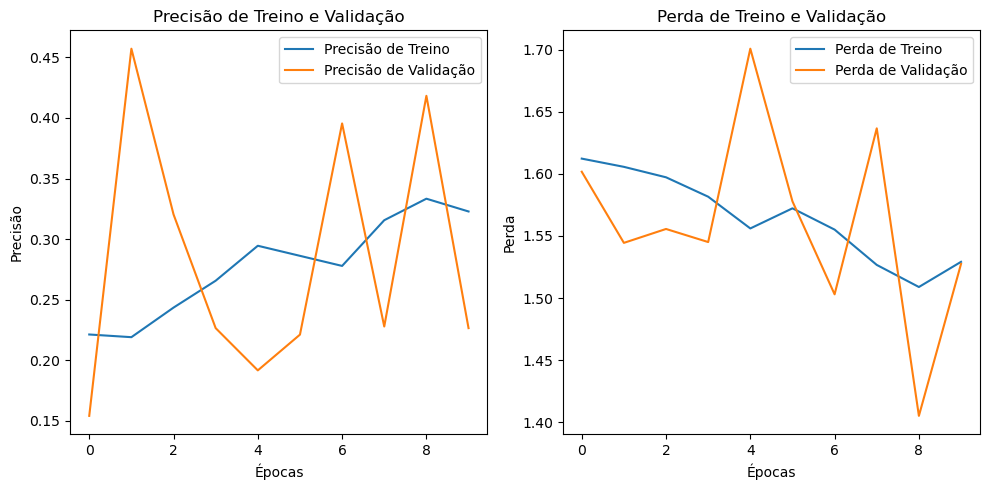

<Figure size 640x480 with 0 Axes>

In [21]:
#Utilização do Grid Search

epochs=10
# Define o grid de parâmetros para amostrar aleatoriamente
param_grid = {
    #'filters': [32, 64, 128],
    #'kernel_size': [(3, 3), (5, 5)],
    #'activation': ['relu', 'tanh']
    'filters': [32,64],
    'kernel_size': (3, 3),
    'activation': ['relu','tanh']
}

# Chamada da função de busca em grade de hiperparâmetros
best_grid_model, final_model, grid_history,model_name_grid = grid_search(CNN_model, train_generator, test_generator, param_grid,epochs)


Modelo carregado com sucesso!
Arquitetura do modelo:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 250, 112)     3136      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 125, 125, 112)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 125, 125, 112)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 56)      56504     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 56)       0         
 2D)                                                             
                                                                 
 dr

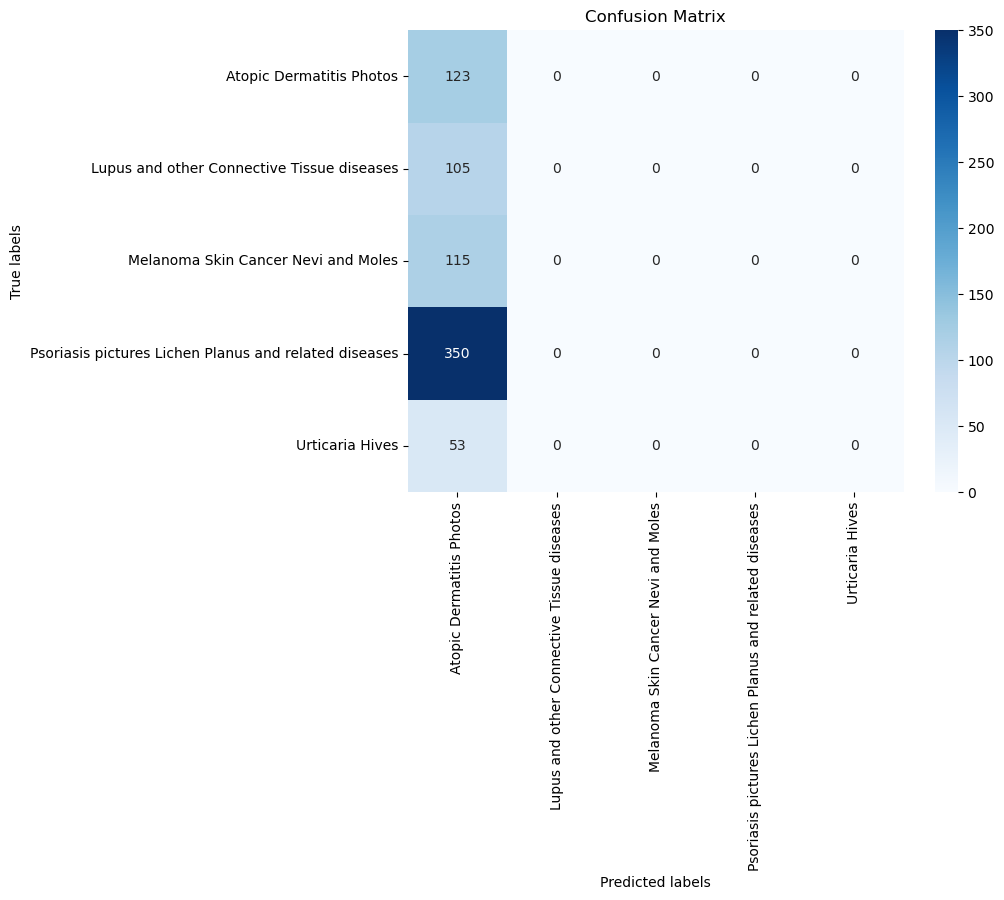


Relatório de Classificação:
                                                       precision    recall  f1-score   support

                             Atopic Dermatitis Photos       0.16      1.00      0.28       123
           Lupus and other Connective Tissue diseases       0.00      0.00      0.00       105
                  Melanoma Skin Cancer Nevi and Moles       0.00      0.00      0.00       115
Psoriasis pictures Lichen Planus and related diseases       0.00      0.00      0.00       350
                                      Urticaria Hives       0.00      0.00      0.00        53

                                             accuracy                           0.16       746
                                            macro avg       0.03      0.20      0.06       746
                                         weighted avg       0.03      0.16      0.05       746


Valores de TP, TN, FP, FN:
Verdadeiros Positivos: 0
Verdadeiros Negativos: 123
Falsos Positivos: 0
Falsos Negati

C:\Users\mariana\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mariana\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mariana\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [30]:
#View of Grid Search Model

loaded_model_CNN_grid, loaded_history_CNN_grid= load_model_and_history(model_name_grid)
if loaded_model_CNN_random is not None:
    print("Modelo carregado com sucesso!")
    print("Arquitetura do modelo:")
    loaded_model_CNN_random.summary()
    if loaded_history_CNN_random is not None:
        print("Histórico do modelo:")
        print(loaded_history_CNN_random.head())  # Visualizar as primeiras linhas do histórico

print("\nA fazer previsões no modelo...")
# Fazer previsões no conjunto de teste usando o modelo carregado
loaded_model_predictions = loaded_model_CNN_random.predict(test_generator)

# Converter as previsões em rótulos
y_pred_labels = np.argmax(loaded_model_predictions, axis=1)
y_true_labels = test_generator.classes

# Agora você pode chamar a função de matriz de confusão
confussion_matrix(y_true_labels, y_pred_labels, test_generator)


#### VGG16

In [17]:
def VGG16_model(hp=None, params=None):
    if hp is not None:
        filters = hp.Int('filters', min_value=32, max_value=256, step=32)
        activation = hp.Choice('activation', values=['relu', 'tanh'])
        learning_rate = hp.Choice('learning_rate', values=[0.001, 0.01, 0.1])
    elif params is not None:
        filters = params.get('filters') if 'filters' in params else 64
        activation = params.get('activation') if 'activation' in params else 'relu'
        learning_rate = params.get('learning_rate') if 'learning_rate' in params else 0.001
    else:
        raise ValueError("Ambos hp e params não podem ser None.")
    
    input_shape = (250, 250, 3)
    resized_input = tf.keras.layers.experimental.preprocessing.Resizing(224, 224)(Input(shape=input_shape))
    
    vgg16_base = VGG16(include_top=False, weights=None, input_tensor=resized_input)
    vgg16_layer = vgg16_base.layers[-1].output
    
    x = GlobalAveragePooling2D()(vgg16_layer)
    x = Dense(units=128, activation=activation)(x)
    x = Dropout(rate=0.2)(x)
    
    output_layer = Dense(units=5, activation='softmax')(x)
    
    model = Model(inputs=resized_input, outputs=output_layer)
    
    opt = Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

Trial 2 Complete [00h 38m 46s]
val_accuracy: 0.46916890144348145

Best val_accuracy So Far: 0.46916890144348145
Total elapsed time: 01h 17m 18s


2024-04-09 01:30:08.848607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - ETA: 0s - loss: 1.6086 - accuracy: 0.2124 

2024-04-09 01:47:18.851504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 1162s 21s/step - loss: 1.6086 - accuracy: 0.2124 - val_loss: 1.5863 - val_accuracy: 0.1649


2024-04-09 01:49:30.819083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


24/24 [==============================] - 132s 5s/step
Precision: 0.027185202222397918
Recall: 0.1648793565683646
Accuracy: 0.1648793565683646


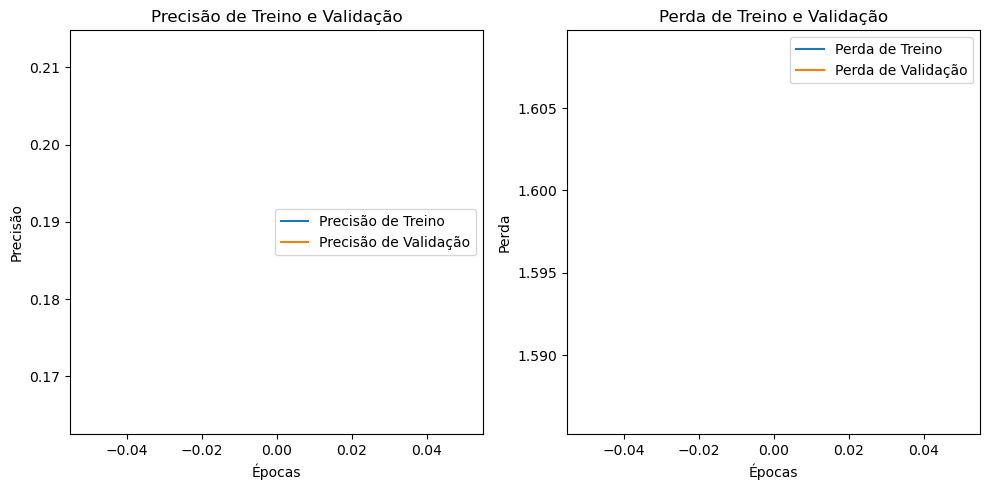

Modelo carregado com sucesso!
Arquitetura do modelo:
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_

<Figure size 640x480 with 0 Axes>

In [26]:
#Utilização do Random Search 
epochs = 1
best_random_model, random_history, model_name = random_hyperparameter_search(
    VGG16_model,  
    train_generator, 
    test_generator, 
    epochs,
    max_trials=2,  # Altere o número de tentativas conforme necessário
    executions_per_trial=2
)

loaded_model, loaded_history = load_model_and_history(model_name)
if loaded_model is not None:
    print("Modelo carregado com sucesso!")
    print("Arquitetura do modelo:")
    loaded_model.summary()
    if loaded_history is not None:
        print("Histórico do modelo:")
        print(loaded_history.head())  # Visualizar as primeiras linhas do histórico

In [22]:
#VIEW MODEL OF RANDOM SEARCH
loaded_model_VGG16, loaded_history_VGG16 = load_model_and_history('VGG16_model_randomsearch')
if loaded_model_VGG16 is not None:
    print("Modelo VGG16 carregado com sucesso!")
    print("Arquitetura do modelo:")
    loaded_model_VGG16.summary()
    if loaded_history_VGG16 is not None:
        print("Histórico do modelo:")
        print(loaded_history_VGG16.head())  # Visualizar as primeiras linhas do histórico

print("\nA fazer previsões no modelo VGG16...")
# Fazer previsões no conjunto de teste usando o modelo VGG16 carregado
loaded_model_predictions_VGG16 = loaded_model_VGG16.predict(test_generator)

# Converter as previsões em rótulos
y_pred_labels_VGG16 = np.argmax(loaded_model_predictions_VGG16, axis=1)
y_true_labels_VGG16 = test_generator.classes

# Agora você pode chamar a função de matriz de confusão
confussion_matrix(y_true_labels_VGG16, y_pred_labels_VGG16, test_generator)

O modelo especificado não existe.

A fazer previsões no modelo VGG16...


AttributeError: 'NoneType' object has no attribute 'predict'

In [ ]:
#Utilização do Grid Search

epochs=10
# Define o grid de parâmetros para amostrar aleatoriamente
param_grid = {
    'filters': [32, 64, 128, 256],  # Valores possíveis para o número de filtros
    'activation': ['relu', 'tanh'],  # Valores possíveis para a função de ativação
    'learning_rate': [0.001, 0.01, 0.1]  # Valores possíveis para a taxa de aprendizado
}

# Chamada da função de busca em grade de hiperparâmetros
best_grid_model, final_model, grid_history,model_name_grid = grid_search(VGG16_model, train_generator, test_generator, param_grid,epochs)


Training model with parameters: {'filters': 32, 'activation': 'relu', 'learning_rate': 0.001}
Epoch 1/10
57/57 [==============================] - 1552s 27s/step - loss: 1.6115 - accuracy: 0.2063 - val_loss: 1.5953 - val_accuracy: 0.4692
Epoch 2/10
57/57 [==============================] - 1540s 27s/step - loss: 1.6083 - accuracy: 0.2058 - val_loss: 1.5861 - val_accuracy: 0.4692
Epoch 3/10
57/57 [==============================] - 1538s 27s/step - loss: 1.6085 - accuracy: 0.2108 - val_loss: 1.5848 - val_accuracy: 0.4692
Epoch 4/10
16/57 [=======>......................] - ETA: 18:42 - loss: 1.6097 - accuracy: 0.2246

In [ ]:
#VIEW MODEL OF RANDOM SEARCH
loaded_model_VGG16, loaded_history_VGG16 = load_model_and_history('VGG16_gridsearch')
if loaded_model_VGG16 is not None:
    print("Modelo VGG16 carregado com sucesso!")
    print("Arquitetura do modelo:")
    loaded_model_VGG16.summary()
    if loaded_history_VGG16 is not None:
        print("Histórico do modelo:")
        print(loaded_history_VGG16.head())  # Visualizar as primeiras linhas do histórico

print("\nA fazer previsões no modelo VGG16...")
# Fazer previsões no conjunto de teste usando o modelo VGG16 carregado
loaded_model_predictions_VGG16 = loaded_model_VGG16.predict(test_generator)

# Converter as previsões em rótulos
y_pred_labels_VGG16 = np.argmax(loaded_model_predictions_VGG16, axis=1)
y_true_labels_VGG16 = test_generator.classes

# Agora você pode chamar a função de matriz de confusão
confussion_matrix(y_true_labels_VGG16, y_pred_labels_VGG16, test_generator)

#### Random e Grid Search Resnet

In [24]:
def ResNet_model(input_shape=(250, 250, 3), params=None):
    input_layer = Input(shape=input_shape)
    resized_input = tf.keras.layers.experimental.preprocessing.Resizing(224, 224)(input_layer)
    
    resnet_base = ResNet50(include_top=False, weights=None, input_tensor=resized_input)
    resnet_output = resnet_base.output
    
    x = GlobalAveragePooling2D()(resnet_output)
    
    # Verifica se há parâmetros definidos
    if params:
        units = params.get('units', 128)
        dropout = params.get('dropout', 0.2)
    else:
        units = 128
        dropout = 0.2
        
    x = Dense(units=units, activation='relu')(x)
    x = Dropout(rate=dropout)(x)
    
    output_layer = Dense(units=5, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

In [ ]:
#Utilização do Random Search

epochs = 10
best_random_model, random_history, model_name = random_hyperparameter_search(
    ResNet_model,  # Use ResNet_model aqui
    train_generator, 
    test_generator, 
    epochs,
    max_trials=2,  # Altere o número de tentativas conforme necessário
    executions_per_trial=2
)


In [ ]:
#View Random Search
loaded_model_ResNet, loaded_history_ResNet = load_model_and_history('ResNet_randomsearch')
if loaded_model_ResNet is not None:
    print("Modelo ResNet carregado com sucesso!")
    print("Arquitetura do modelo:")
    loaded_model_ResNet.summary()
    if loaded_history_ResNet is not None:
        print("Histórico do modelo:")
        print(loaded_history_ResNet.head())  # Visualizar as primeiras linhas do histórico

print("\nA fazer previsões no modelo ResNet...")
# Fazer previsões no conjunto de teste usando o modelo ResNet carregado
loaded_model_predictions_ResNet = loaded_model_ResNet.predict(test_generator)

# Converter as previsões em rótulos
y_pred_labels_ResNet = np.argmax(loaded_model_predictions_ResNet, axis=1)
y_true_labels_ResNet = test_generator.classes

# Agora você pode chamar a função de matriz de confusão
confussion_matrix(y_true_labels_ResNet, y_pred_labels_ResNet, test_generator)


In [ ]:
#Utilização do Grid Search

param_grid = {
    'units': [64, 128, 256],
    'dropout': [0.1, 0.2, 0.3]
}
best_model_grid, final_model_grid, final_history_grid, model_name_grid = grid_search_resnet(ResNet_model, train_generator, test_generator, param_grid, epochs=10)

#### DOESNT WORK

Modelo CNN Grid Search carregado com sucesso!
Modelo CNN Random Search carregado com sucesso!
Melhor modelo: CNN Random Search
24/24 [==============================] - 11s 432ms/step


AttributeError: 'DataFrame' object has no attribute 'history'

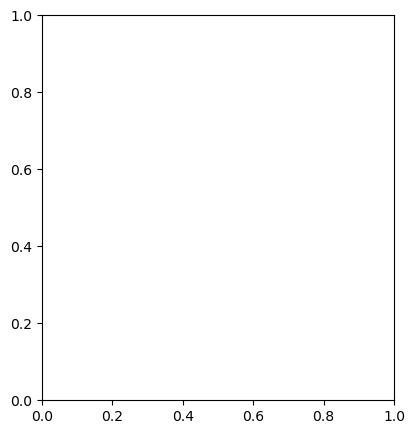

In [33]:
loaded_model_CNN_grid, loaded_history_CNN_grid= load_model_and_history(model_name_grid)
if loaded_model_CNN_random is not None:
    print("Modelo CNN Grid Search carregado com sucesso!")

loaded_model_CNN_random, loaded_history_CNN_random = load_model_and_history('CNN_randomsearch')
if loaded_model_CNN_random is not None:
    print("Modelo CNN Random Search carregado com sucesso!")

# Comparar a acurácia dos modelos
best_accuracy_grid = max(loaded_history_CNN_grid['val_accuracy'])
best_accuracy_random = max(loaded_history_CNN_random['val_accuracy'])

# Guardar apenas o melhor modelo
if best_accuracy_grid > best_accuracy_random:
    best_model = loaded_model_CNN_grid
    best_history = loaded_history_CNN_grid
    print("Melhor modelo: CNN Grid Search")
else:
    best_model = loaded_model_CNN_random
    best_history = loaded_history_CNN_random
    print("Melhor modelo: CNN Random Search")

# Avaliação do modelo
evaluate_model(best_model, best_history, test_generator, test_folder)

# Previsão usando o conjunto de teste
y_pred = best_model.predict(test_generator)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = test_generator.classes

# Matriz de confusão
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
print(conf_matrix)

# Salvar o melhor modelo
save_model(best_model, 'best_CNN_model', history, train_folder, test_folder, test_generator)

### Compilação de Modelos SEM TUNNING

#### CNN 2D

In [ ]:
# Definição da arquitetura da CNN
def CNN_model(input_shape=(250, 250, 3)):
    model = Sequential([
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        GlobalAveragePooling2D(),
        
        Dense(units=64, activation='relu'),
        Dense(units=5, activation='softmax')
    ])

    return model

# Execução do modelo CNN
def run_cnn_model(train_folder, test_folder, epochs=50):
    # Obtendo os dados
    train_generator, validation_generator, test_generator,_,_,_ = get_data(train_folder, test_folder)
    
    # Criação e compilação do modelo CNN
    model = CNN_model()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Treino do modelo
    history = model.fit(train_generator, validation_data=validation_generator, epochs=epochs, verbose=1)
    
    # Avaliação do modelo
    evaluate_model(model, history, test_generator, test_folder)

    #Verificcar se o y_pred e o y_pred_labels estao direitos
    # Prever usando o conjunto de teste
    y_pred = model.predict(test_generator)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = test_generator.classes
    
    confussion_matrix(y_true_labels,y_pred_labels,test_generator)

    # Guardar o modelo
    save_model(model, 'CNN_model', history, train_folder, test_folder, test_generator)

# Execução do modelo CNN
run_cnn_model(train_folder, test_folder)

In [ ]:
# Obter o modelo 
model = CNN_model()

# Sumário do modelo
model.summary()

#### ResNet50

In [ ]:
# Definição da arquitetura da ResNet
def ResNet_model(input_shape=(250, 250, 3)):
    input_layer = Input(shape=(250, 250, 3))
    resized_input = tf.keras.layers.experimental.preprocessing.Resizing(224, 224)(input_layer)
    
    resnet_base = ResNet50(include_top=False, weights=None, input_tensor=resized_input)
    resnet_output = resnet_base.output
    
    x = GlobalAveragePooling2D()(resnet_output)
    x = Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu')(x)
    x = Dropout(rate=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1))(x)
    
    output_layer = Dense(units=5, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Execução do modelo ResNet
def run_resnet_model(train_folder, test_folder, epochs=50):
    # Obtendo os dados
    train_generator, validation_generator, test_generator,_,_,_ = get_data(train_folder, test_folder)
    
    # Criação e compilação do modelo ResNet
    model = ResNet_model()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Treino do modelo
    history = model.fit(train_generator, validation_data=validation_generator, epochs=epochs, verbose=1)
    
    # Avaliação do modelo
    evaluate_model(model, history, test_generator, test_folder)
    
    # Prever usando o conjunto de teste
    y_pred = model.predict(test_generator)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = test_generator.classes
    
    confussion_matrix(y_true_labels,y_pred_labels,test_generator)
    
    # Guardar o modelo
    save_model(model, 'ResNet_model', history, train_folder, test_folder, test_generator)

# Execução do modelo ResNet
run_resnet_model(train_folder, test_folder)

In [ ]:
# Obter o modelo 
model = ResNet_model()

# Sumário do modelo
model.summary()

#### VGG16

In [ ]:
# Função para definir a arquitetura do modelo VGG16
def VGG16_model(weights=None, input_shape=(250, 250, 3)):
    # Camada de entrada
    input_layer = Input(shape=input_shape)

    # Redimensionar as imagens de entrada para 224x224 para corresponder à forma de entrada do VGG16
    resized_input = tf.keras.layers.experimental.preprocessing.Resizing(224, 224)(input_layer)

    # Importar o modelo VGG16 da API do Keras
    vgg16_base = VGG16(include_top=False, weights=weights, input_tensor=resized_input)

    # Remover a última camada do VGG16, que é um GlobalAveragePooling2D
    vgg16_layer = vgg16_base.layers[-1].output

    # Camada de saída
    x = Flatten()(vgg16_layer)
    x = Dense(units=128, activation='relu')(x)
    x = Dropout(rate=0.2)(x)
    output_layer = Dense(units=5, activation='softmax')(x)

    # Modelo
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

from sklearn.metrics import confusion_matrix, classification_report

# Execução do modelo VGG16
def run_vgg16_model(train_folder, test_folder, epochs=50):
    # Obtenção de dados
    train_generator, validation_generator, test_generator,_,_,_ = get_data(train_folder, test_folder)
    
    # Criação e compilação do modelo VGG16
    model = VGG16_model()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Treino do modelo
    history = model.fit(train_generator, validation_data=validation_generator, epochs=epochs, verbose=1)
    
    # Avaliação do modelo
    evaluate_model(model, history, test_generator, test_folder)
    
    # Prever usando o conjunto de teste
    y_pred = model.predict(test_generator)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = test_generator.classes
    
     confussion_matrix(y_true_labels,y_pred_labels,test_generator)
    # Guardar o modelo
    save_model(model, 'VGG16_model', history, train_folder, test_folder, test_generator)

# Execução do modelo VGG16
run_vgg16_model(train_folder, test_folder)


In [ ]:
# Obter o modelo
model = VGG16_model()

# Sumário do modelo 
model.summary()